# L02 - Introduction to FEniCS - Darcy


<img style="float: left;" src="fig/fenics_logo.png" width=200>


In this notebook will will intruce the concept of pressure driven flow in porous media, as described by Darcy's equation. You will learn how to: 
 - Solve for a Darcian pressure field 
 - Postprocess a velocity field for application to fluid flow in porous media
 

## Porous flow and Darcy's equation in steady state
[wiki] <img style="float: left;" src="fig/Darcy.png" width=400> 


### Mathematical formulation:

Darcy's law is an equation that describes the flow of a fluid through a porous medium. 
In the absence of gravitational forces, it provides a simple relationship between the flow rate through a porous medium and the pressure drop over a given distance. For homogeneous permeable medium with permeability ${\kappa}$ and fluid dynamic viscosity ${\mu}$, one we can derive: 

$$ q =  - \: \frac {\kappa} {\mu} \:  \nabla P \:\:\:\:\:\:\:\:\:\:\:\:  (1) $$ 

where $q$ is the fluid discharge per unit area (m/s) and $∇p$ is the fluid pressure gradient vector (Pa/m). The discharge flux is often referred to as the Darcy flux or Darcy velocity, and is a average quantity of the fluid front through the porous media, it is different from the local fluid velocity traveling through the pore network. The fluid velocity $v_f$ can be recovered by rescaling the Darcy flux $q$ by the porosity of the media $\phi$.

$$ v_f =  \frac {q} {\phi}  $$ 

As now, we have one equation for two unknowns (the Darcy flux and the pressure gradient). By using the mass balance equation of the fluid, one can derive an expression for the fluid pressure:

$$ \frac {\partial \: \phi\rho_f} {\partial t} = \nabla \cdot \rho_f v_f  $$ 

Which simplies for constant fluid density $\rho_f$ and constant porosity field $\phi$ to: 

$$ \nabla \cdot v_f =  0 \:\:\:\:\:\: or \:\:\:\:\:\: \nabla \cdot q =  0 \:\:\:\:\:\:\:\:\:\:\:\:  (2) $$ 



Using equation (1) in (2) gives:

$$ \nabla \cdot   ( - \: \frac {\kappa} {\mu} \:  \nabla P ) =  0 $$ 

We have derive a Poisson equation as an expression for the fluid pressure field. One can solve this equation given some boundary conditions.




## First, let's import the FEniCS library through the DOLFIN import

In [1]:
%matplotlib inline

# Import all the functions from DOLFIN (computational backend of the FEniCS project)
from dolfin import * 

## Discretizing the domain and space of functions
We can now use FEniCS to solve our problem. First, we discretize our domain by creating a mesh of $\Omega$. 

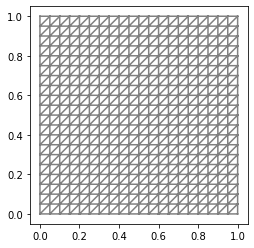

In [2]:
mesh = UnitSquareMesh(20,20) # 20 is number of intervals Omega is divided intoc
plot(mesh);

elem = FiniteElement("CG", triangle, 1) # here interval is a FEniCS builtin representing a single interval
W = FunctionSpace(mesh, elem)


## Specifying the weak formulation
Next, all we need to do is tell FEniCS the weak formulation of our problem.

In [3]:
kappa_over_mu = Constant(1.0) # physical material property
phi = Constant(0.1) # porosity, ranging from 0 to 1
S = Constant(0.0) # source term

V = TestFunction(W) # the test function
U = TrialFunction(W) # the TrialFunction is basically a symbol representing the unknown
U_old = Function(W) # Solution at previous time step. Initialized to zero.

a = kappa_over_mu * dot( grad(U), grad(V) ) * dx  # left hand side of our equation
L = (S*V) * dx # right hand side of our equation

## Set the boundary conditions
Next, all we need to do is tell FEniCS the weak formulation of our problem.

In [4]:
value_left = Constant(1.0)
value_right = Constant(0.0)
bc_l = DirichletBC(W, value_left, "on_boundary && near(x[0], 0)") # Imposing Dirichlet BC to the left boundary node
bc_r = DirichletBC(W, value_right, "on_boundary && near(x[0], 1)") # Imposing Dirichlet BC to the right boundary node
bcs = [bc_l, bc_r]   # list of boundary conditions to apply to the problem

## Solve for the pressure field

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


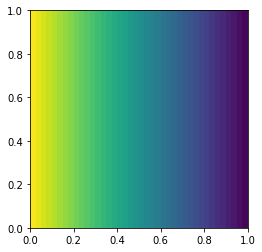

In [5]:
p_sol = Function(W)  # place to store the solution
solve(a == L, p_sol, bcs)
plot(p_sol);

## Estimate the veolcity field from the pressure field (postprocessing)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


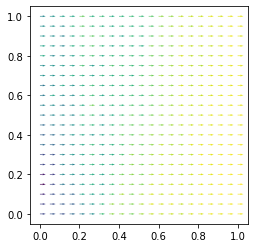

In [6]:
elem_v = VectorElement("DG", triangle, 0) # This is new typoe of element (for vector field discretization)
W_v = FunctionSpace(mesh, elem_v)
grad_p = project(grad(p_sol), W_v)
vel_f = - kappa_over_mu * grad_p / phi
plot(vel_f);

## Paraview!

In [7]:
# In order to send our velocity field to Paraview, we need to project it on a continuous field.  
elem_viz = VectorElement("CG", triangle, 1) # yet another element
W_viz = FunctionSpace(mesh, elem_viz)
v_viz = project(vel_f, W_viz)

v_file = File('Darcy_vel.pvd')
p_file = File('Darcy_p.pvd')
v_file << v_viz
p_file << p_sol